<a href="https://colab.research.google.com/github/fboldt/aulasann/blob/main/aula7a_MLP_Regulariza%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

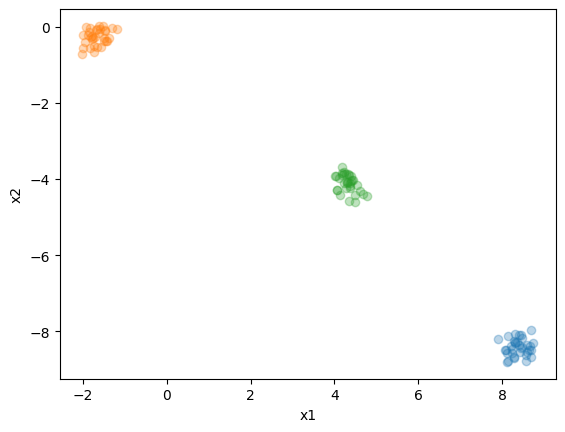

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

def criaDataset(n=100, centros=3):
  X, y = make_blobs(n_samples=n, centers=centros, cluster_std=0.2)
  return X, y

X, y = criaDataset()

def plotDataset(X, y):
  plt.xlabel("x1")
  plt.ylabel("x2")
  for k in set(y):
    plt.plot(X[:,0][y==k],X[:,1][y==k], "o", alpha=0.3)

plotDataset(X, y)

In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score

def include_bias(X):
  bias = np.ones((X.shape[0], 1))
  Xb = np.concatenate((bias, X), axis=1)
  return Xb

def defineAxes(X):
    offset = 0.5
    min1, max1 = X[:, 0].min(), X[:, 0].max()
    min2, max2 = X[:, 1].min(), X[:, 1].max()
    return [min1-offset, max1+offset, min2-offset, max2+offset]

def plotPredictions(clf, X):
    axes = defineAxes(X)
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)

In [9]:
from scipy.special import expit
from abc import ABC, abstractmethod

class ActivationFunction(ABC):
  @abstractmethod
  def forward(self, a):
    pass
  @abstractmethod
  def backward(self, a):
    pass

class TanH(ActivationFunction):
  def forward(self, a):
    return expit(a)*2-1
  def backward(self, a):
    return (1 - np.square(self.forward(a)))

class Sigmoid(ActivationFunction):
  def forward(self, a):
    return expit(a)
  def backward(self, a):
    return self.forward(a) * (1 - self.forward(a))

0.99

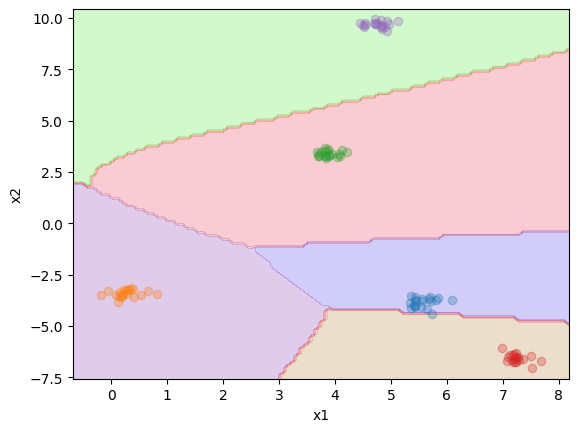

In [60]:
from sklearn.preprocessing import label_binarize

class Backpropagation(BaseEstimator, ClassifierMixin):
  def __init__(self, max_iter=1000, learning_rate=0.001, n_hidden=[2],
               activation=TanH(), regularization=0):
    self.max_iter = max_iter
    self.learning_rate = learning_rate
    self.n_hidden = n_hidden
    self.activation = activation
    self.regularization = regularization

  def forward(self, X):
    self.A = []
    self.Z = []
    AUX = X.copy()
    for W in self.Ws:
      self.A.append(include_bias(AUX))
      self.Z.append(self.A[-1] @ W)
      AUX = self.activation.forward(self.Z[-1])
    return AUX

  def backward(self, X, y, ypred):
    grads = []
    output_delta = y - ypred
    grads.insert(0, self.A[-1].T @ output_delta)
    for i in range(len(self.Ws)-1, 0, -1):
      tanh_grad = self.activation.backward(self.Z[i-1])
      input_delta = (output_delta @ self.Ws[i][1:,:].T) * tanh_grad
      grads.insert(0, self.A[i-1].T @ input_delta)
      output_delta = input_delta.copy()
    for i in range(len(self.Ws)-1, -1, -1):
      self.Ws[i] *= 1 - self.regularization * self.learning_rate
      self.Ws[i] += grads[i] * self.learning_rate

  def encode_labels(self, y):
    self.labels = list(set(y))
    return label_binarize(y, classes=self.labels)

  def fit(self, X, y):
    yhot = self.encode_labels(y)
    self.Ws = []
    previous_output = X.shape[1]
    for layer_size in self.n_hidden:
      self.Ws.append(np.random.uniform(-1, 1, size=(previous_output+1, layer_size)))
      previous_output = self.Ws[-1].shape[1]
    self.Ws.append(np.random.uniform(-1, 1, size=(previous_output+1, yhot.shape[1])))
    for _ in range(self.max_iter):
      ypred = self.forward(X)
      self.backward(X, yhot, ypred)

  def predict(self, X):
    a = self.forward(X)
    if len(self.labels) <= 2:
      idx = np.array(a > 0, dtype=int).reshape(-1,)
    else:
      idx = np.argmax(a, axis=1)
    ypred = np.array([self.labels[i] for i in idx])
    return ypred

X, y = criaDataset(centros=5)
clf = Backpropagation(n_hidden=[50], regularization=10)
clf.fit(X, y)
plotDataset(X, y)
plotPredictions(clf, X)
ypred = clf.predict(X)
accuracy_score(y, ypred)

1.0

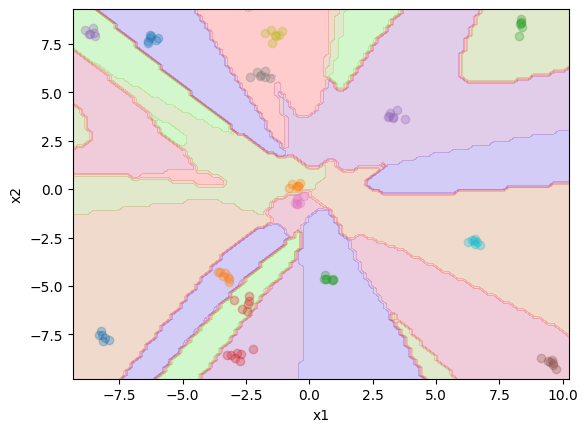

In [69]:
# X, y = criaDataset(centros=15)
clf = Backpropagation(n_hidden=[100, 100], regularization=0)
clf.fit(X, y)
plotDataset(X, y)
plotPredictions(clf, X)
ypred = clf.predict(X)
accuracy_score(y, ypred)

In [93]:
from sklearn.model_selection import cross_validate

scores = cross_validate(Backpropagation(n_hidden=[100], regularization=0.1),
                        X, y, return_train_score=True)
scores

{'fit_time': array([0.37338352, 0.35101104, 0.38927698, 0.3540895 , 0.35660839]),
 'score_time': array([0.00078201, 0.00077033, 0.00134659, 0.00075221, 0.0007596 ]),
 'test_score': array([0.9 , 0.95, 1.  , 0.95, 1.  ]),
 'train_score': array([0.9625, 0.9625, 0.9875, 0.9375, 1.    ])}

In [88]:
from sklearn.neural_network import MLPClassifier

scores = cross_validate(MLPClassifier(), X, y)
scores

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

{'fit_time': array([0.21830845, 0.1938386 , 0.19795108, 0.21121716, 0.19173884]),
 'score_time': array([0.00129724, 0.00117588, 0.00122976, 0.00203371, 0.00198889]),
 'test_score': array([0.9 , 0.95, 0.95, 1.  , 0.95])}